In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
import Performance
performance=Performance.performance()

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## plot routines

In [26]:
## Plotting routines
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import gridspec

def get_hamp_IWV_for_periods_around_all_sonde_locations(internal_iwv_sonde,half_period="30s"):
    #hamp_gradients using 1min mean
    hamp_iwv_internal=pd.DataFrame()
    hamp_iwv_internal_mean=pd.Series(data=np.nan,index=internal_iwv_sonde.index)
    for t,sonde_time in enumerate(internal_iwv_sonde.index):
        print(sonde_time)
        if flight[0]=="RF06" and ar_of_day=="AR_entire_1" and t==0:
            sonde_period_start= pd.Timestamp("2022-03-16 12:01")-pd.Timedelta(half_period)
            sonde_period_end  = pd.Timestamp("2022-03-16 12:01")+pd.Timedelta(half_period)
        else:    
            sonde_period_start= pd.Timestamp(sonde_time)-pd.Timedelta(half_period)
            sonde_period_end  = pd.Timestamp(sonde_time)+pd.Timedelta(half_period)
        temporary_series=IWV_retrieved.loc[str(sonde_period_start):\
                                                             str(sonde_period_end)]
        temporary_series.index=range(temporary_series.shape[0])
        hamp_iwv_internal[sonde_time]=temporary_series
        mean_iwv_hamp_values=IWV_retrieved.loc[str(sonde_period_start):\
                                                             str(sonde_period_end)].mean()
        hamp_iwv_internal_mean.loc[sonde_time]=mean_iwv_hamp_values.mean()
    return hamp_iwv_internal,hamp_iwv_internal_mean

def plot_internal_iwv_tendency(sonde_times_series,Dropsondes,IWV_retrieved,sector_to_plot="warm"):
    # ---- Add this one : internal_sondes_dict["cold"]
    matplotlib.rcParams.update({"font.size":28})
    # Internal sondes iwv
    time_list=[str(time) for time in sonde_times_series.index]
    Dropsondes["new_alt"]=Dropsondes["alt"].copy()
    new_key_list=[]
    # IWV from internal sondes
    for key in [*Dropsondes["alt"].keys()]:
        new_key=str(pd.Timestamp(key))
        Dropsondes["alt"][new_key] = Dropsondes["alt"].pop(key)
    iwv_sonde=Dropsondes["IWV"].iloc[internal_sondes_dict[sector_to_plot]]
    minutes_to_divide=iwv_sonde.index.to_series().diff().astype('timedelta64[m]')[-1]
    iwv_sonde_diff=iwv_sonde.diff()[-1]/minutes_to_divide*60

    #hamp_gradients using 1min mean
    hamp_iwv_internal,hamp_iwv_internal_mean=get_hamp_IWV_for_periods_around_all_sonde_locations(iwv_sonde)
    #hamp_iwv_internal_mean=pd.Series(data=np.nan,index=iwv_sonde.index)
    #for t,sonde_time in enumerate(iwv_sonde.index):
    #    if flight[0]=="RF06" and ar_of_day=="AR_entire_1" and t==0:
    #        sonde_period_start= pd.Timestamp("2022-03-16 12:01")-pd.Timedelta("30s")
    #        sonde_period_end  = pd.Timestamp("2022-03-16 12:01")+pd.Timedelta("30s")
    #    else:    
    #        sonde_period_start= pd.Timestamp(sonde_time)-pd.Timedelta("30s")
    #        sonde_period_end  = pd.Timestamp(sonde_time)+pd.Timedelta("30s")
    # 
    #    mean_iwv_sonde_values=IWV_retrieved.loc[str(sonde_period_start):\
    #                                                         str(sonde_period_end)].mean()
    #    hamp_iwv_internal_mean.loc[sonde_time]=mean_iwv_sonde_values

    hamp_iwv_diff=hamp_iwv_internal_mean.diff()/minutes_to_divide*60
    icon_iwv_diff=pd.Series(data=np.nan, index=iwv_sonde.index)

    iwv_sonde_fig=plt.figure(figsize=(8,14))
    ax1=iwv_sonde_fig.add_subplot(111)
    matplotlib.rcParams['axes.linewidth'] = 3
    ax1.patch.set_facecolor('lightgrey')
    ax1.patch.set_alpha(0.5)
    time_key_list=[*Dropsondes["q"].keys()]
    if sector_to_plot=="warm":
        colors=["darkorange","moccasin"]
    else:
        colors=["darkviolet","plum"]

    for c,sonde_time in enumerate(internal_sondes_dict[sector_to_plot]):
        if sector_to_plot=="warm":
            relevant_timestamp=time_key_list[sonde_time]
            ax1.scatter(Dropsondes["q"][relevant_timestamp]*1000,Dropsondes["alt"][str(relevant_timestamp)]/1000,
            color="k",s=140)
            ax1.scatter(Dropsondes["q"][relevant_timestamp]*1000,Dropsondes["alt"][str(relevant_timestamp)]/1000,
                label="Sonde "+str(relevant_timestamp),color=colors[c],s=80)
            iwv_sonde=Dropsondes["q"][relevant_timestamp]
        else:
            relevant_timestamp=pd.Timestamp(sonde_time)
        
        icon_q_sondes={}
        icon_z_sondes={}
        if relevant_timestamp>halo_df.index[-1]:
            icon_q_sondes["Sonde"+str(c)]=snd_halo_icon_hmc["q"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                         relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_z_sondes["Sonde"+str(c)]=snd_halo_icon_hmc["Z_Height"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                                relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_iwv_diff.iloc[c]=snd_halo_icon_hmp["Interp_IWV"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                            relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
        else:
            icon_q_sondes["Sonde"+str(c)]=halo_icon_hmc["q"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                         relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_z_sondes["Sonde"+str(c)]=halo_icon_hmc["Z_Height"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                                relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_iwv_diff.iloc[c]=halo_icon_hmp["Interp_IWV"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                            relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
        ax1.scatter(icon_q_sondes["Sonde"+str(c)]*1000,
                icon_z_sondes["Sonde"+str(c)]/1000,
                marker="v", s=150, color=colors[c],edgecolor="k",
                label="ICON "+str(relevant_timestamp))
    if sector_to_plot=="warm":
        iwv_icon_diff_h=icon_iwv_diff.diff()[-1]/minutes_to_divide*60
    else:
        iwv_icon_diff_h=icon_iwv_diff.diff()[-1]/minutes_to_divide*60
    ax1.set_xlabel("Specific humidity (${\mathrm{gkg}}^{-1}$)")
    ax1.set_ylabel("Height (km)")
    ax1.set_xlim([0,5])
    ax1.set_ylim([0,12])
    if sector_to_plot=="warm":
        ax1.text(1.4,7,"$\dfrac{\delta {IWV}_{\mathrm{Sonde}}}{\delta t}=$"+str(round(iwv_sonde_diff,2))+" $\mathrm{mmh}^{-1}$",
         fontsize=25)
        ax1.text(1.4,6,"$\dfrac{\delta {IWV}_{\mathrm{ICON}}}{\delta t}=$"+str(round(iwv_icon_diff_h,2))+" $\mathrm{mmh}^{-1}$",
         fontsize=25)
        ax1.text(1.4,5,"$\dfrac{\delta {IWV}_{\mathrm{HAMP}}}{\delta t}=$"+str(round(hamp_iwv_diff[-1],2))+" $\mathrm{mmh}^{-1}$",
        fontsize=25)
    ax1.xaxis.set_tick_params(width=3,length=10)
    ax1.yaxis.set_tick_params(width=3,length=10)
    ax1.legend(fontsize=24)
    sns.despine(offset=10)
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_sonde_iwv_tendency.png"
    iwv_sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

## Retrieval functions

In [3]:
def get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=5000):
    idx_height=np.argmin(abs(np.array(retrieval_coeff_heights)-halo_height))
    relevant_height=retrieval_coeff_heights[idx_height]
    return idx_height,relevant_height

def open_height_relevant_retrieval(retrieval_coeff_heights,var_to_retrieve,act_halo_height,
                                   coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\"+\
                                   "PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python\\"+\
                                   "Flight_Data\\HALO_AC3\\retrieval\\"):
    height=act_halo_height.copy()
    idx_height,relevant_height=get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=height)
    m_est_height=pd.read_csv(coeff_path+var_to_retrieve+"_Retrieval_coeffs_several_dates_"+str(relevant_height)+".csv",
                            index_col="Unnamed: 0")
    return m_est_height

## Switches and Definitions

In [4]:
campaign="HALO_AC3"
ar_of_day="AR_entire_1"
calibrated_hamp=True
flight=["RF05"]
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
sector_to_plot="warm"
take_arbitary=False
do_plotting=True
plot_path=start_path+"/../plots/"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

## Get the flight track data

In [5]:
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#        
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""    
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)

## Get Reanalysis and Model data

### ERA-5

In [6]:
import reanalysis as Reanalysis
file_name="total_columns_"+cmpgn_cls.years[flight[0]]+"_"+\
                    cmpgn_cls.flight_month[flight[0]]+"_"+\
                    cmpgn_cls.flight_day[flight[0]]+".nc"    
        
era5=Reanalysis.ERA5(for_flight_campaign=True,campaign="HALO_AC3",
                  research_flights=flight,
                  era_path=cmpgn_cls.campaign_path+"/data/ERA-5/")
        
ds,era_path=era5.load_era5_data(file_name)
        
#IVT Processing
ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)
ds["IVT_conv"]=ds["p84.162"]*3600 # units in seconds

### ICON

In [7]:
icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
icon_resolution=2000 # units m
icon_var_list=ICON.lookup_ICON_AR_period_data(campaign,flight,ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)
halo_df=halo_df.rename(columns={"lat":"latitude",
                                "lon":"longitude"})

ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
                            cmpgn_cls,icon_var_list,halo_df,flight,flight_dates[flight[0]],
                            interpolated_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv",
                            interpolated_hmc_file=None,ar_of_day=ar_of_day,
                            synthetic_icon=False,
                            synthetic_flight=False)
if campaign=="HALO_AC3":
    hydrometeor_icon_path=hydrometeor_icon_path+flight[0]+"/"
    ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
    
# ICON Values on HALO
halo_icon_hmc=ICON_on_HALO.load_hwc(with_hydrometeors=False)
halo_icon_hmp=ICON_on_HALO.load_interpolated_hmp()        
#Second ar of day
snd_ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(cmpgn_cls,icon_var_list,halo_df,flight,flight_dates[flight[0]],
                interpolated_hmp_file=flight[0]+"_"+"AR_entire_2"+"_"+"interpolated_HMP.csv",
                interpolated_hmc_file=None,ar_of_day="AR_entire_2",
                synthetic_icon=False,synthetic_flight=False)
if campaign=="HALO_AC3":
    snd_ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
    # ICON Values on HALO
    snd_halo_icon_hmc=snd_ICON_on_HALO.load_hwc(with_hydrometeors=False)
    snd_halo_icon_hmp=snd_ICON_on_HALO.load_interpolated_hmp()

File of interest: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/ICON_LEM_2KM/RF05/RF05_AR_entire_1_V_Wind_interpolated_profile.csv
Changed Latitude of HALO Aircraft for Synthetic Observations
RF05_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened
File of interest: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/ICON_LEM_2KM/RF05/RF05_AR_entire_2_V_Wind_interpolated_profile.csv
Changed Latitude of HALO Aircraft for Synthetic Observations
RF05_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened


### Process dropsondes

In [8]:
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)
    
sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))

if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
            internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-15 14:30","2022-03-15 15:25"]
            internal_times=["2022-03-15 13:20","2022-03-15 14:25"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
if flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-16 10:45","2022-03-16 11:21"]
            internal_times=["2022-03-16 11:25","2022-03-16 12:10"]
            outflow_times=["2022-03-16 12:15","2022-03-16 12:50"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]

new_halo_dict={flight[0]:{"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
                          "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
                          "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}}

from atmospheric_rivers import Atmospheric_Rivers
AR_inflow,AR_outflow=Atmospheric_Rivers.locate_AR_cross_section_sectors(
                                    new_halo_dict,ERA5_on_HALO.halo_era5,
                                    flight[0])

relevant_sondes_dict={}
internal_sondes_dict={}
if take_arbitary:
    for sector in ["warm_sector","core","cold_sector"]:
        print("Analyse frontal sector ",sector)
        #add_sonde=1
        #if sector=="core":
        #    add_sonde=1
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]
        
        relevant_sondes_dict[sector]       = {}
        relevant_sondes_dict[sector]["in"] = sonde_times_series.loc[AR_sector_in.index[0]:AR_sector_in.index[-1]]
        relevant_sondes_dict[sector]["out"]= sonde_times_series.loc[AR_sector_out.index[0]:AR_sector_out.index[-1]]
        
else:
    if flight[0]=="RF05":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
            relevant_cold_sector_sondes=[4,5,6]
            relevant_warm_internal_sondes=[7,13]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            #relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            synthetic_sonde_times_series=pd.Series(data=["7synth","8synth","9synth"],
                                     index=pd.DatetimeIndex(["2022-03-15 12:55","2022-03-15 13:05","2022-03-15 13:15"]))
            relevant_sondes_dict["cold_sector"]["out"] = synthetic_sonde_times_series
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
            internal_sondes_dict["cold"]               = ["2022-03-15 11:30:00","2022-03-15 13:35"]   
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[9,10,11,12,15,16,17,18]
            relevant_cold_sector_sondes=[19,20,21]
            relevant_warm_internal_sondes=[13,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = pd.Series()#sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
    elif flight[0]=="RF06":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,8,9,10]
            relevant_cold_sector_sondes=[3,4,5,11,12]
            relevant_warm_internal_sondes=[7,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:3]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[3:]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3:]]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[8,9,16,17]
            relevant_cold_sector_sondes=[10,11,12,18,19]
            relevant_warm_internal_sondes=[21,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:2]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[2::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]

## Radiometer dataset

Typhon module cannot be loaded
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/HALO_HALO_AC3_radiometer_unified_*20220315_v0*.nc
Plotting ...
TBKVDF: Index(['22.24', '23.04', '23.84', '25.44', '26.24', '27.84', '31.4', '50.3',
       '51.76', '52.8', '53.75', '54.94', '56.66', '58.0'],
      dtype='object')
Figure saved as :  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/Flight_Data/HALO_AC3/plots/radiometer/HAMP_Tb_20220315_RF05.png


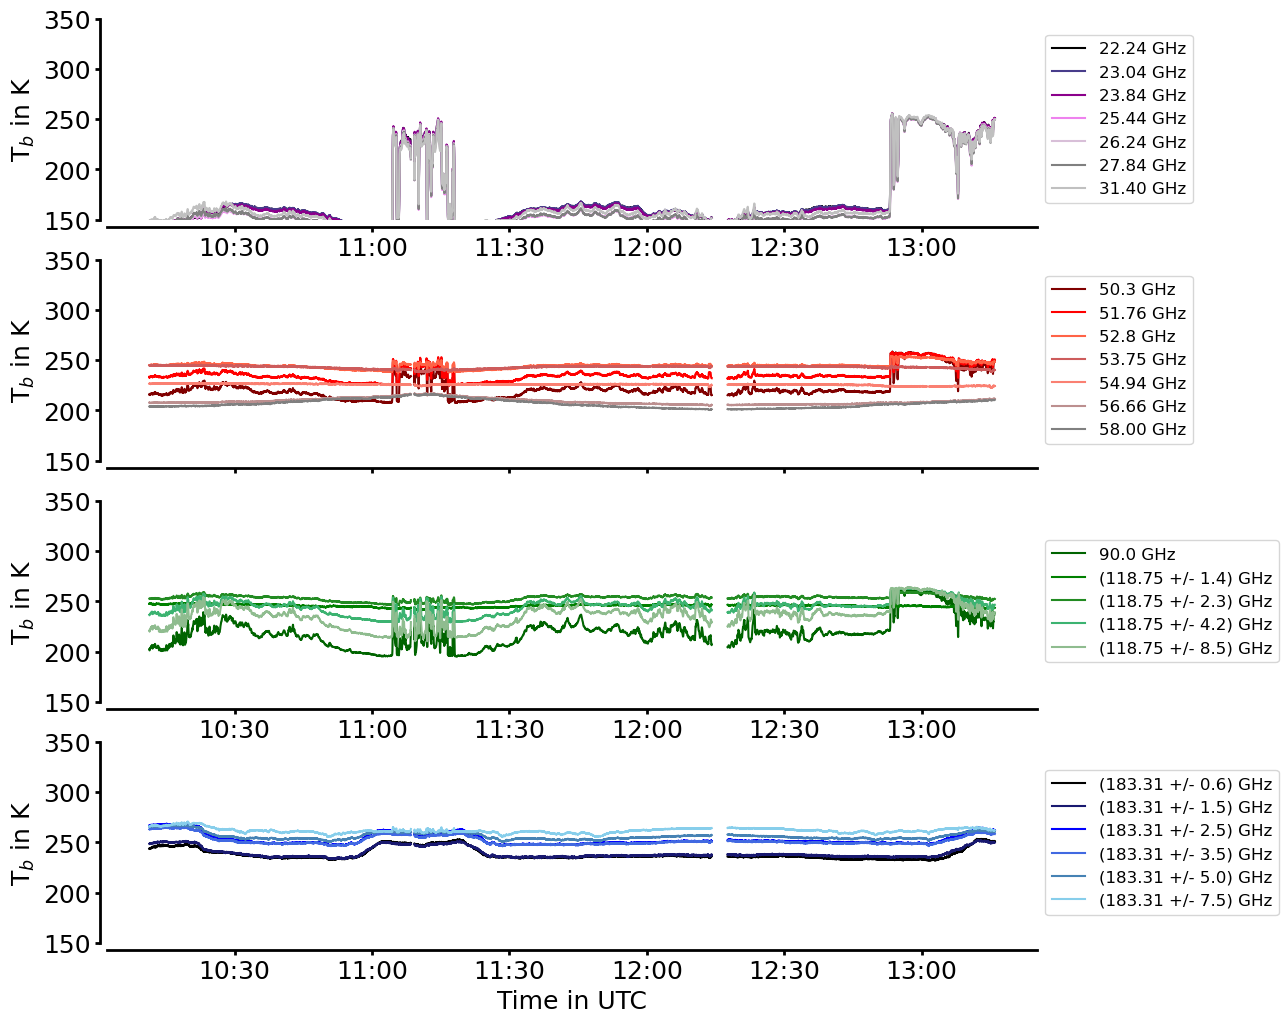

In [9]:
# processing_path packages
import data_config
import measurement_instruments_ql
import campaign_netcdf
import halodataplot as Data_Plotter
import quicklook_dicts
radar_dict={}
bahamas_dict={}  
campaign=cmpgn_cls.name
airborne_data_importer_path=major_work_path+\
                                "hamp_processing_py/"+\
                                    "hamp_processing_python/Flight_Data/"+campaign+"/"
date=flight_dates[flight[0]]
###############################################################################
inflow=False
# Radar reflectivity
cfg_dict=quicklook_dicts.get_prcs_cfg_dict(flight,date,campaign,cmpgn_cls.campaign_path)
cfg_dict["device_data_path"]=airborne_data_importer_path
with HiddenPrints():
    # Data Handling 
    datasets_dict, data_reader_dict=quicklook_dicts.get_data_handling_attr_dicts()
    # Get Plotting Handling
    plot_handler_dict, plot_cls_args_dict,plot_fct_args_dict=\
                            quicklook_dicts.get_plotting_handling_attrs_dict()

HALO_Devices_cls=measurement_instruments_ql.HALO_Devices(cfg_dict)
HALO_Devices_cls.update_major_data_path(cmpgn_cls.campaign_path)
Bahamas_cls=measurement_instruments_ql.BAHAMAS(HALO_Devices_cls)
Radar_cls=measurement_instruments_ql.RADAR(HALO_Devices_cls)
Radiometer_cls=measurement_instruments_ql.HAMP(HALO_Devices_cls)
import halodataplot as halo_data_plotter
    
Quick_Plotter=Data_Plotter.Quicklook_Plotter(cfg_dict)
Radiometer_Quicklook=halo_data_plotter.Radiometer_Quicklook(cfg_dict)
calibrated_hamp=False
Radiometer_cls.open_processed_hamp_data(open_calibrated=calibrated_hamp,
                            newest_version=True)
if not calibrated_hamp:
    mwr=Radiometer_cls.processed_hamp_ds
else:
    mwr=Radiometer_cls.calib_processed_hamp_ds
if pd.Timestamp(inflow_times[0])<pd.Timestamp(outflow_times[-1]):
    mwr_cutted=mwr.sel({"time":slice(inflow_times[0],outflow_times[-1])})
else:
    mwr_cutted=mwr.sel({"time":slice(outflow_times[0],inflow_times[-1])})
Radiometer_Quicklook.radiometer_tb_dict=mwr_cutted
Radiometer_Quicklook.cfg_dict["Flight_Dates_used"]
Radiometer_Quicklook.plot_radiometer_TBs(flight[0],raw_measurements=False)

### Prepare IWV Regression Retrieval

In [10]:
import retrieval
import PAMTRA_sim_analysis

# Predefinitions
coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\PhD_UHH_WIMI\\Work\\GIT_Repository"+\
            "\\hamp_processing_py\\hamp_processing_python\\Flight_Data\\HALO_AC3\\retrieval\\"
var_to_retrieve="q"
order=2

# # get all relevant retrieval heights
import glob
retrieval_coeff_files=glob.glob(coeff_path+var_to_retrieve+"*")
retrieval_coeff_heights=[int(file.split("_")[-1][:-4]) for file in retrieval_coeff_files]

In [11]:
# Process brightness temperatures
brightness_Ts=pd.DataFrame(data=np.array(mwr["TB"][:]),
                           index=pd.DatetimeIndex(np.array(mwr.time[:])),
                           columns=np.array(mwr.freq[:]))
brightness_Ts=brightness_Ts.sort_index(axis=1)
# The retrieved hamp Q profiles for divergence calculations will rely on smoothened TBs
smoothed_brightness_Ts=brightness_Ts.rolling("10s",min_periods=8).mean()
# Initialize Retrieval class, most attributes are unused
regr_retrieval=retrieval.Regression_Retrieval
#Smoothed_Q_Retrieval=regr_retrieval(xr.Dataset(),"q",smoothed_brightness_Ts,order,[date],os.getcwd(),
#                      added_noise=True)
#Smoothed_Q_Retrieval.y=smoothed_brightness_Ts
#Smoothed_Q_Retrieval.build_K_reg()
#TB_K_reg_smoothed=Smoothed_Q_Retrieval.K_reg

### IWV Retrieval

<Axes: >

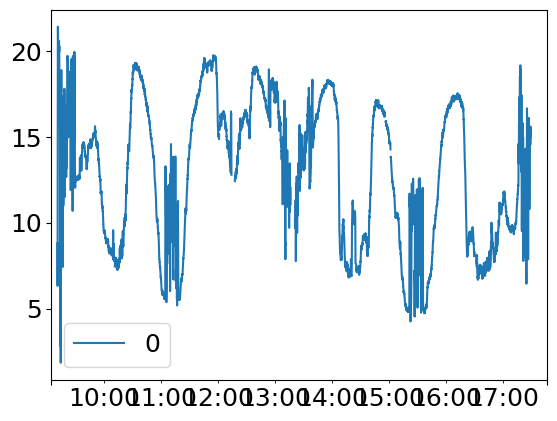

In [12]:
retrieval_coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\"+\
                                   "PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python\\"+\
                                   "Flight_Data\\HALO_AC3\\retrieval\\"
# Sonde retrieval
retrieved_var_file_name=retrieval_coeff_path+flight[0]+"_retrieved_IWV.csv"
if not os.path.exists(retrieved_var_file_name):
    #create IWV retrieval
    # Retrieval class
    Smoothed_IWV_Retrieval=regr_retrieval(xr.Dataset(),"IWV",smoothed_brightness_Ts,order,["20220315"],os.getcwd(),
                          added_noise=True)
    Smoothed_IWV_Retrieval.y=smoothed_brightness_Ts
    Smoothed_IWV_Retrieval.build_K_reg()

    IWV_retrieved=pd.Series(data=np.nan, index=smoothed_brightness_Ts.index)
    # Define coeff dict 
    coeff_dict_IWV={}
    IWV_retrieval_files=glob.glob(coeff_path+"IWV*")
    retrieval_coeff_heights=[int(file.split("_")[-1][:-4]) for file in retrieval_coeff_files]
    for height in retrieval_coeff_heights:
        coeff_dict_IWV[height]=pd.read_csv(coeff_path+"IWV"+"_Retrieval_coeffs_"+str(height)+".csv",
                             index_col=0)
    # loop over all timesteps
    t_range=smoothed_brightness_Ts.shape[0]
    for t in range(t_range):
        _,relevant_height=get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=5000)
        coeff_IWV=coeff_dict_IWV[relevant_height]
        # coeff dict to m_est
        m_est_IWV=np.zeros(2*len(coeff_IWV.columns)+1)
        reg_coeffs=coeff_IWV.copy()
        for f, freq in enumerate(coeff_IWV.columns):
            m_est_IWV[0]=reg_coeffs.iloc[0,f]
            if f==0:
                m_est_IWV[1]=reg_coeffs.iloc[1,f]
                m_est_IWV[2]=reg_coeffs.iloc[2,f]
            else:
                m_est_IWV[2*(f+1)-1] = reg_coeffs.iloc[1,f]
                m_est_IWV[2*(f+1)]   = reg_coeffs.iloc[2,f]
        IWV_retrieved.iloc[t]=m_est_IWV.dot(Smoothed_IWV_Retrieval.K_reg[t,:].T)
        performance.updt(t_range,t)
    IWV_retrieved.to_csv(retrieved_var_file_name)
    print("IWV retrieval saved as:",retrieval_coeff_path+retrieved_var_file_name)
else:
    IWV_retrieved=pd.read_csv(retrieved_var_file_name,index_col=0)
    IWV_retrieved.index=pd.DatetimeIndex(IWV_retrieved.index)
IWV_retrieved.plot()

2022-03-15 11:52:30
2022-03-15 14:00:48
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1_warm_sonde_iwv_tendency.png


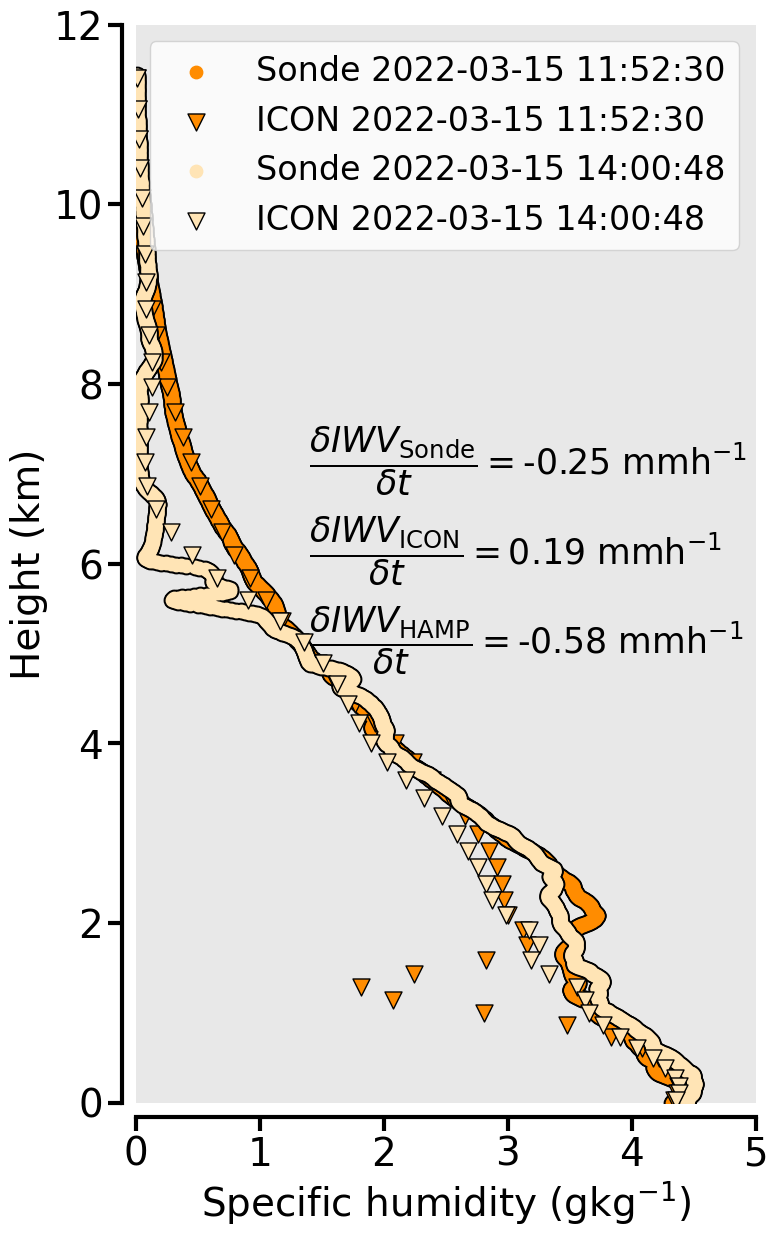

In [29]:
plot_internal_iwv_tendency(sonde_times_series,Dropsondes,IWV_retrieved,sector_to_plot="warm")

In [23]:
IWV_retrieved.max()

0    21.44171
dtype: float64

In [25]:
sonde_times_series

2022-03-15 10:19:22     0
2022-03-15 10:28:33     1
2022-03-15 10:34:37     2
2022-03-15 10:41:45     3
2022-03-15 10:49:06     4
2022-03-15 10:55:47     5
2022-03-15 11:03:29     6
2022-03-15 11:52:30     7
2022-03-15 12:05:05     8
2022-03-15 12:28:34     9
2022-03-15 12:36:29    10
2022-03-15 12:40:08    11
2022-03-15 12:43:47    12
2022-03-15 14:00:48    13
2022-03-15 14:11:44    14
2022-03-15 14:34:01    15
2022-03-15 14:40:56    16
2022-03-15 14:47:58    17
2022-03-15 14:54:30    18
2022-03-15 15:01:07    19
2022-03-15 15:05:56    20
2022-03-15 15:13:18    21
2022-03-15 16:09:45    22
2022-03-15 16:22:53    23
2022-03-15 16:44:06    24
dtype: int64

2022-03-15 11:52:30
2022-03-15 14:00:48


KeyError: 'Halo_Lon'

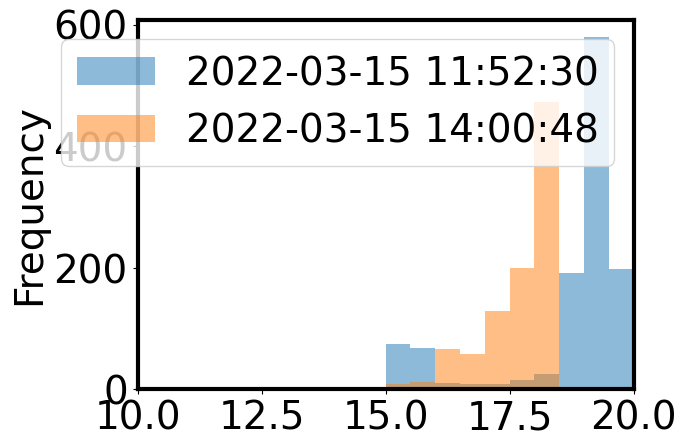

In [39]:
time_list=[str(time) for time in sonde_times_series.index]
Dropsondes["new_alt"]=Dropsondes["alt"].copy()
new_key_list=[]
# IWV from internal sondes
for key in [*Dropsondes["alt"].keys()]:
    new_key=str(pd.Timestamp(key))
    Dropsondes["alt"][new_key] = Dropsondes["alt"].pop(key)
iwv_sonde=Dropsondes["IWV"].iloc[internal_sondes_dict[sector_to_plot]]
#hamp_gradients using 1min mean
hamp_iwv_internal,hamp_iwv_internal_mean=get_hamp_IWV_for_periods_around_all_sonde_locations(iwv_sonde,half_period="10min")
#hamp_iwv_internal_mean
ax = hamp_iwv_internal.plot.hist(bins=np.linspace(15,20,11), alpha=0.5,xlim=[10,20])

plt.scatter(halo_df["Halo_Lon"],halo_df["Halo_Lat"])

In [ ]:
# Sonde retrieval
"""
retrieved_var_file_name=retrieval_coeff_path+flight[0]+"_retrieved_IWV.csv"
if not os.path.exists(retrieval_coeff_path+retrieved_var_file_name):
    #create IWV retrieval
    # Retrieval class
    Smoothed_IWV_Retrieval=regr_retrieval(xr.Dataset(),"IWV",smoothed_brightness_Ts,order,["20220315"],os.getcwd(),
                          added_noise=True)
    Smoothed_IWV_Retrieval.y=smoothed_brightness_Ts
    Smoothed_IWV_Retrieval.build_K_reg()

    IWV_retrieved=pd.Series(data=np.nan, index=smoothed_brightness_Ts.index)
    # Define coeff dict 
    coeff_dict_IWV={}
    IWV_retrieval_files=glob.glob(coeff_path+"IWV*")
    retrieval_coeff_heights=[int(file.split("_")[-1][:-4]) for file in retrieval_coeff_files]
    for height in retrieval_coeff_heights:
        coeff_dict_IWV[height]=pd.read_csv(coeff_path+"IWV"+"_Retrieval_coeffs_"+str(height)+".csv",
                             index_col=0)
    # loop over all timesteps
    t_range=smoothed_brightness_Ts.shape[0]
    for t in range(t_range):
        _,relevant_height=get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=5000)
        coeff_IWV=coeff_dict_IWV[relevant_height]
        # coeff dict to m_est
        m_est_IWV=np.zeros(2*len(coeff_IWV.columns)+1)
        reg_coeffs=coeff_IWV.copy()
        for f, freq in enumerate(coeff_IWV.columns):
            m_est_IWV[0]=reg_coeffs.iloc[0,f]
            if f==0:
                m_est_IWV[1]=reg_coeffs.iloc[1,f]
                m_est_IWV[2]=reg_coeffs.iloc[2,f]
            else:
                m_est_IWV[2*(f+1)-1] = reg_coeffs.iloc[1,f]
                m_est_IWV[2*(f+1)]   = reg_coeffs.iloc[2,f]
        IWV_retrieved.iloc[t]=m_est_IWV.dot(Smoothed_IWV_Retrieval.K_reg[t,:].T)
        performance.updt(t_range,t)
    IWV_retrieved.to_csv(retrieved_var_file_name)
    print("IWV retrieval saved as:",retrieval_coeff_path+retrieved_var_file_name)
else:
    IWV_retrieved=pd.read_csv(retrieved_var_file_name)
IWV_retrieved.plot()
"""